In [100]:
from typing import List, Tuple
from abc import ABC, abstractmethod
from enum import Enum
import random
import json

from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.circuit.library import XGate, IGate, RYGate
from qiskit import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2

In [2]:
class Shell:
    BLANK=0
    LIVE=1

In [3]:
class Play:
    HIMSELF=0
    OPPONENT=1

In [5]:
class Player(ABC):

    def __init__(self, life:int, name:str):
        self._life = life
        self._points = 0
        self._name = name

    @abstractmethod
    def play(self, bullets:List[Shell]) -> Play:
        """Think and then play"""
        pass

    def decrease_life(self):
        self._life -= 1

    def add_point(self):
        self._points += 1

    @property
    def name(self) -> str:
        return self._name

    @property
    def points(self) -> int:
        return self._points

    @property
    def life(self) -> int:
        return self._life

    @property
    def is_alive(self) -> bool:
        return self._life > 0

    def __str__(self):
        return self._name
    
    def __repr__(self):
        return self._name

In [6]:
class Game:
    def __init__(
        self,
        bullets: List[Shell],
        players: List[Player]
    ):
        self._bullets = bullets
        self._players = players

        self._rounds = 0

        self._total_players = len(players)
        self._current_player_i = 0

    def _get_next_player_i(self) -> int:
        return (self._current_player_i+1)%self._total_players

    @property
    def _opponent(self) -> Player:
        return self._players[self._get_next_player_i()]

    def _set_next_player(self):
        self._current_player_i = self._get_next_player_i()

    @property
    def _current_player(self) -> Player:
        return self._players[self._current_player_i]

    @property
    def _next_bullet(self) -> Shell:
        bullet = random.choice(self._bullets)
        self._bullets.remove(bullet)
        return bullet

    @property
    def _has_live_shells(self) -> bool:
        return self._bullets.count(Shell.LIVE) > 0

    @property
    def _both_players_are_alive(self) -> bool:
        return all([player.is_alive for player in self._players]) 

    @property
    def _has_ended(self) -> bool:
        return not self._has_live_shells or not self._both_players_are_alive

    @property
    def _winner(self) -> Player:
        return max(self._players, key=lambda p: p.points)


    def run(self, debug:bool=True) -> Tuple[Player, int]:
        while not self._has_ended:
            player = self._current_player
            play = player.play(self._bullets)
            bullet = self._next_bullet

            if(play == Play.HIMSELF and bullet == Shell.BLANK):
                if(debug): print("Player shot himself and it was blank")
                continue
            elif(play == Play.HIMSELF and bullet == Shell.LIVE):
                if(debug):print("Player shot himself and it was live (-1)")
                player.decrease_life()
                self._opponent.add_point()
            elif(play == Play.OPPONENT and bullet == Shell.BLANK):

                if(debug):
                    print("Player shot his opponent and it was blank")
                    print("Next player")
                self._set_next_player()
            elif(play == Play.OPPONENT and bullet == Shell.LIVE):
                if(debug):
                    print("Player shot his opponent and it was Live (+1)")
                    print("Next player")
                self._opponent.decrease_life()
                self._set_next_player()
            
            self._rounds += 1
        
        if(debug): print("End game!")

        return self._winner, self._rounds








In [7]:
class Human1(Player):
    def play(self, bullets:List[Shell]) -> Play:
        total_live = bullets.count(Shell.LIVE)
        prob_of_live_shell = total_live/len(bullets)

        if(prob_of_live_shell >= 0.5):
            return Play.OPPONENT
        return Play.HIMSELF

In [8]:
class Human2(Player):
    def play(self, bullets:List[Shell]) -> Play:
        return Play.OPPONENT

In [9]:
class Human3(Player):
    def play(self, bullets:List[Shell]) -> Play:
        if(random.random() <= 0.5):
            return Play.OPPONENT
        return Play.HIMSELF

In [15]:
class Human4(Player):
    def play(self, bullets:List[Shell]) -> Play:
        return Play.HIMSELF

In [10]:
class Dealer(Player):
    def play(self, bullets:List[Shell]) -> Play:
        if(random.random() <= 0.5):
            return Play.OPPONENT
        return Play.HIMSELF

In [16]:
data_first_strategy = pd.DataFrame(columns=["winner", "rounds"])
data_second_strategy = pd.DataFrame(columns=["winner", "rounds"])
data_third_strategy = pd.DataFrame(columns=["winner", "rounds"])
data_forth_strategy = pd.DataFrame(columns=["winner", "rounds"])

In [12]:
TOTAL_RUNS = 100000

In [18]:
for human_player,df in zip((Human1, Human2, Human3, Human4), (data_first_strategy, data_second_strategy, data_third_strategy, data_forth_strategy)):
    for run in trange(TOTAL_RUNS):
        game = Game([Shell.BLANK, Shell.BLANK, Shell.LIVE], [human_player(2, "player"), Dealer(2, "dealer")])
        winner,rounds = game.run(debug=False)
        df.loc[run] = {"winner":winner.name, "rounds":rounds}

100%|██████████| 100000/100000 [02:58<00:00, 559.32it/s]


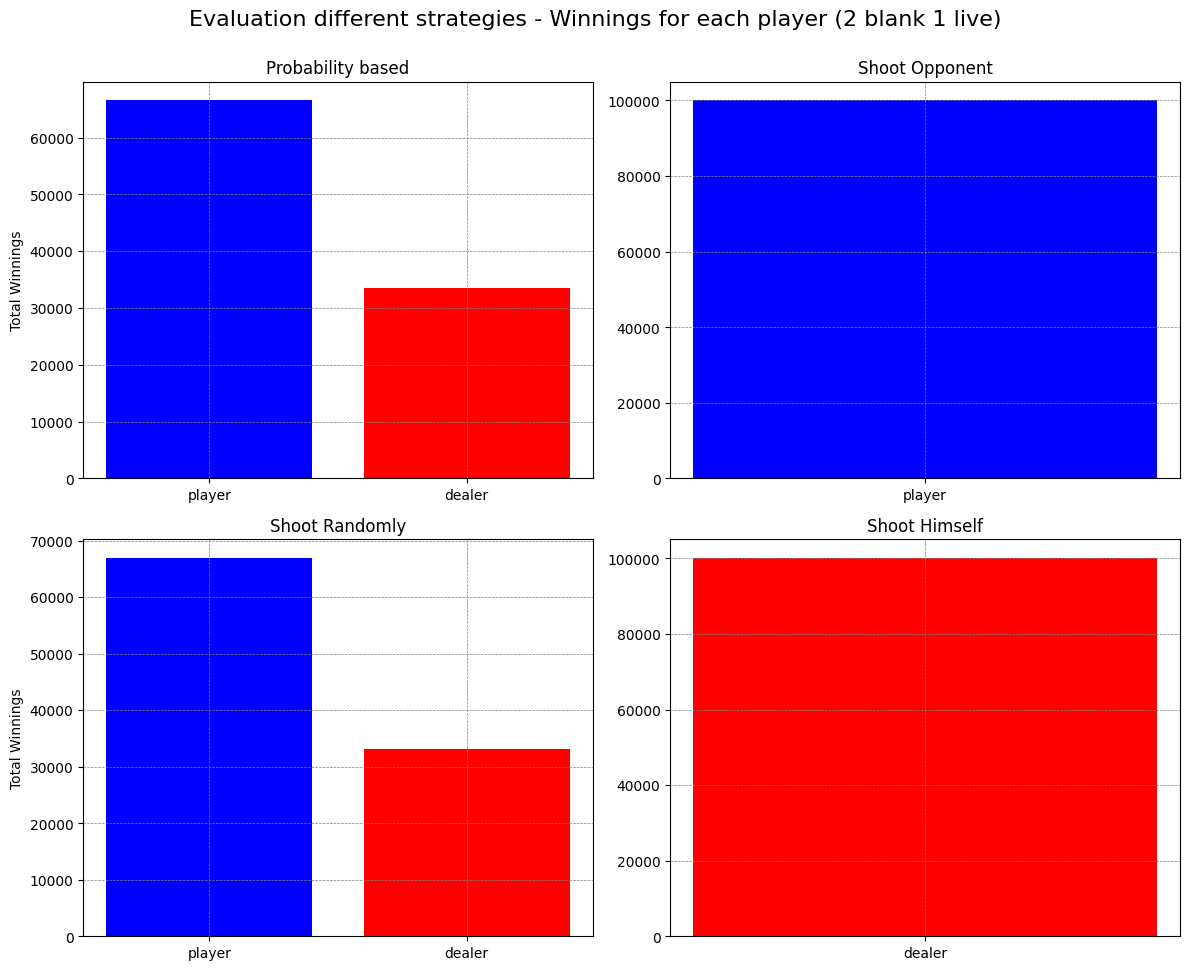

In [58]:
colors = {
    'player':'blue',
    'dealer':'red'
}

plt.figure(figsize=(12,14))
plt.suptitle("Evaluation different strategies - Winnings for each player (2 blank 1 live)", y=1, fontsize=16)

for i, (df, strategy_name) in enumerate(zip((data_first_strategy, data_second_strategy, data_third_strategy, data_forth_strategy), ("Probability based", "Shoot Opponent", "Shoot Randomly", "Shoot Himself"))):
    df.to_csv("%s.csv"%(strategy_name))
    values = df['winner'].value_counts().to_dict()

    plt.subplot(3,2,i+1)
    plt.title(strategy_name)

    bar_labels = list(values.keys())
    bar_colors = [ colors[label] for label in bar_labels ]

    if(i%2 == 0):
        plt.ylabel("Total Winnings")

    plt.grid(color='gray', linestyle='--', linewidth=0.5, which='both')
    plt.bar(height=values.values(), x=values.keys(), label=bar_labels, color=bar_colors)

plt.tight_layout()
plt.savefig("2-blank-1-live-sim.png",bbox_inches="tight")
plt.show()

---

In [65]:
def player1(total_bullets:int, amount_of_live_shells:int):
    prob_of_live_shell = amount_of_live_shells/total_bullets

    if(prob_of_live_shell < 0.5):
        return IGate()
    return XGate()

In [71]:
def player2(total_bullets:int, amount_of_live_shells:int):
    return XGate()

In [72]:
def player3(total_bullets:int, amount_of_live_shells:int):
    if(random.random() <= 0.5):
        return XGate()
    return IGate()

In [73]:
def player4(total_bullets:int, amount_of_live_shells:int):
    return IGate()

In [74]:
def dealer(total_bullets:int, amount_of_live_shells:int):
    if(random.random() <= 0.5):
        return XGate()
    return IGate()

In [81]:
def gun(total_bullets:int, amount_of_live_shells:int):
    theta = 2*np.arcsin(np.sqrt(amount_of_live_shells/total_bullets))
    return RYGate(theta)

In [89]:
def buckshot_roulette(player, dealer, gun, total_bullets:int=3, live_shells:int=1):
    
   
    player_life  = QuantumRegister(3, name="p") 
    dealer_life  = QuantumRegister(3, name="d")

    game = QuantumRegister(3, name="game")

    player_life_out = ClassicalRegister(3, name="po")
    dealer_life_out = ClassicalRegister(3, name="do")
    
    aux = AncillaRegister(1, name="aux")
    
    qc = QuantumCircuit(game, aux, player_life, dealer_life, player_life_out, dealer_life_out)
    
    qc.append(player(total_bullets, live_shells), [game[0]])
    qc.x(game[0])
    qc.append(gun(total_bullets, live_shells).control(1), [game[0], player_life[0]])
    qc.x(game[0])
    qc.append(gun(total_bullets, live_shells).control(1), [game[0], dealer_life[0]])
    
    #next_player
    # 0 = player, 1 = dealer
    
    qc.barrier()
    
    total_bullets -= 1
    qc.append(dealer(total_bullets,live_shells).control(1), [game[0], game[1]])
    qc.x(game[0])
    qc.append(player(total_bullets, live_shells).control(1), [game[0], game[1]])
    qc.x(game[0])
    qc.barrier()
    
    qc.x(game[1])
    qc.append(gun(total_bullets, live_shells).control(2), [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    qc.append(gun(total_bullets, live_shells).control(2), [game[0], game[1], player_life[1]])
    qc.x(game[0])
    
    qc.x(game[1])
    qc.append(gun(total_bullets, live_shells).control(2), [game[0], game[1], player_life[1]])
    qc.x(game[0])
    qc.append(gun(total_bullets, live_shells).control(2), [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    
    qc.barrier()

    total_bullets -= 1

    qc.append(player(total_bullets, live_shells).control(2), [game[0], game[1], game[2]])
    
    qc.x(game[1])
    qc.append(dealer(total_bullets,live_shells).control(2), [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[1])
    
    qc.x(game[0])
    qc.append(dealer(total_bullets,live_shells).control(2), [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[0])
    
    qc.x([game[0], game[1]])
    qc.append(player(total_bullets, live_shells).control(2), [game[0], game[1], game[2]])
    qc.x([game[0], game[1]])
    qc.barrier()
    
    qc.append(gun(total_bullets, live_shells).control(2), [aux, game[2], player_life[2]])
    qc.x(game[2])
    qc.append(gun(total_bullets, live_shells).control(2), [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.x(aux)
    qc.append(gun(total_bullets, live_shells).control(2), [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.append(gun(total_bullets, live_shells).control(2), [aux, game[2], player_life[2]])
    qc.x(aux)
    
    
    qc.barrier()
    qc.measure(player_life, player_life_out)
    qc.measure(dealer_life, dealer_life_out)
    
    return qc

In [90]:
for i,player in enumerate((player1, player2, player3, player4)):
    qc = buckshot_roulette(player, dealer, gun)
    qc.draw('mpl', style="clifford", filename="quantum-buckshot-roulette-player-strategy-%d.png"%(i+1))

In [102]:
sim = AerSimulator()
sampler = SamplerV2()
pm = generate_preset_pass_manager(backend=sim, optimization_level=2)

In [159]:
results = []

for i,player in enumerate((player1, player2, player3, player4)):
    print("Simulating player %d"%(i+1))
    qc = buckshot_roulette(player, dealer, gun)
    isa_qc = pm.run(qc)

    result = sampler.run([isa_qc], shots=1000).result()[0]
    measurements = dict(result.join_data().get_counts()),
    results.append(measurements[0])

Simulating player 1
Simulating player 2
Simulating player 3
Simulating player 4


In [161]:
with open("quantum-aer-sim-results.json", "w") as file:
    json.dump(results, file)

In [170]:
# clean results
winnings = {}
for i,result in enumerate(results):
    strategy_handle = 'strategy_%d'%(i+1)
    winnings[strategy_handle] = {'player':0, 'dealer':0}

    for bit_string, total in result.items():
        dealer = list(bit_string[:3][::-1])
        player = list(bit_string[3:][::-1])

        for p,d in zip(player,dealer):

            if(p == '1'):
                winnings[strategy_handle]['dealer'] += total
            elif(d == '1'):
                winnings[strategy_handle]['player'] += total

In [171]:
with open("clean-quantum-aer-sim-results.json", "w") as file:
    json.dump(winnings, file)

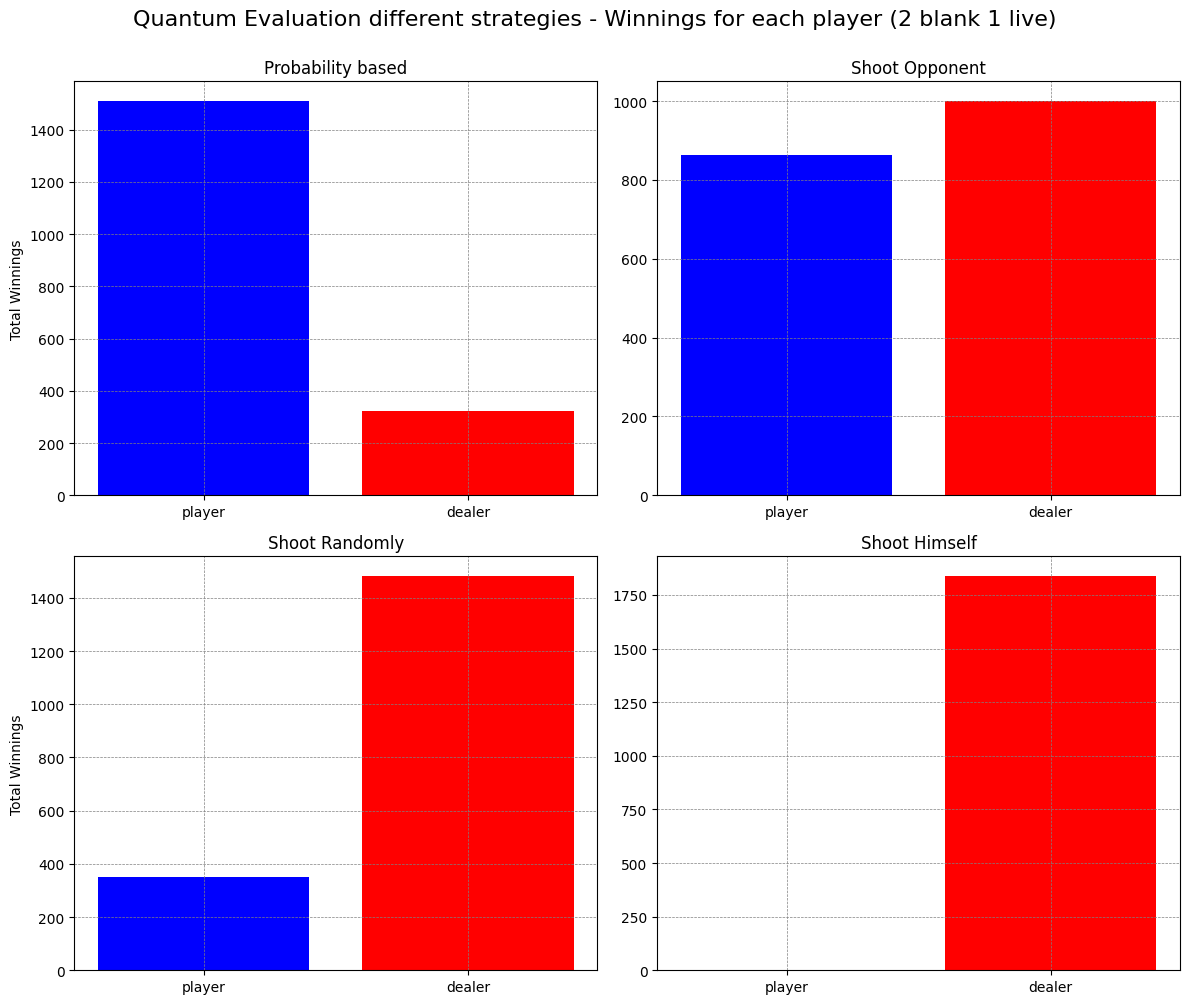

In [ ]:

plt.figure(figsize=(12,10))
plt.suptitle("Quantum Evaluation different strategies - Winnings for each player (2 blank 1 live)", y=1, fontsize=16)


for i,(result, strategy) in enumerate(zip(winnings.values(), ("Probability based", "Shoot Opponent", "Shoot Randomly", "Shoot Himself"))):
    plt.subplot(2,2,i+1)

    plt.title(strategy)

    if(i % 2 == 0):
        plt.ylabel("Total Winnings")

    plt.bar(x=result.keys(), height=result.values(), label=colors.keys(), color=colors.values())
    plt.grid(color='gray', linestyle='--', linewidth=0.5, which='both')

plt.tight_layout()
plt.savefig("2-blank-1-live-sim-quantum.png", bbox_inches="tight")
plt.show()